In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
import datetime as dt

import os
# import DataProcessor as dp

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
def retrieve_summary(zone_lkup_file, taxi_file_names, gb_field):
    taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
    # chunk_list = []  # append each chunk df here     
    gb_field_list = ["trip_count","total_revenue","total_time_min","total_miles"]

    gb_final_file_df = pd.DataFrame()

    for file_key in taxi_file_names: 
        clean_file_df = clean_file(taxi_file_names[file_key], taxi_zone_lkup_df, file_key, gb_field)
        gb_clean_file_df = groupby(clean_file_df, gb_field, gb_field_list)
        gb_final_file_df = gb_final_file_df.append(gb_clean_file_df)
        print(file_key)

    gb_final_file_df = groupby(gb_final_file_df, gb_field, gb_field_list)
    gb_final_file_df = enrich_summary(gb_final_file_df)
    
    return gb_final_file_df

def enrich_summary(df):
    new_df = df
    new_df['avg_min_ptrip'] = new_df['total_time_min']/new_df['trip_count']
    new_df['avg_dist_ptrip'] = new_df['total_miles']/new_df['trip_count']
    new_df['avg_rev_ptrip'] = new_df['total_revenue']/new_df['trip_count']
    
    new_df['avg_dist_pmin'] = new_df['total_miles']/new_df['total_time_min']
    new_df['avg_rev_pmin'] = new_df['total_revenue']/new_df['total_time_min']
    
    return new_df


def clean_file(csv, taxi_zone_lkup_df, file_key, gb_field):
    
    chunks_df = pd.read_csv(csv, chunksize=1000000)    
    gb_field_list = ["PULocationID","total_amount","trip_time_min","trip_distance"]
    
    new_gb_df = pd.DataFrame()    
    
    for chunk_df in chunks_df:  
        clean_chunk_df = clean_chunk(chunk_df, taxi_zone_lkup_df, file_key)
        gb_clean_chunk_df = groupby(clean_chunk_df, gb_field, gb_field_list)
        # Once the data filtering is done, append the chunk to list
        new_gb_df = new_gb_df.append(gb_clean_chunk_df)
    return new_gb_df


def clean_chunk(df, zone_lkup_df, file_key):
    new_df = remove_unwanted_columns(df)
    new_df = remove_unwanted_rows(new_df, file_key)
    new_df = add_new_columns(new_df, zone_lkup_df)
    return new_df

def remove_unwanted_columns(df):
    new_df = df.drop(['VendorID', 'store_and_fwd_flag','fare_amount',
                    'extra', 'mta_tax','tolls_amount',
                    'improvement_surcharge'], axis=1) 
    return new_df

def remove_unwanted_rows(df, file_key):
    new_df = df 
    new_df['year'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).year
    new_df['month'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).month
    
    file_month = file_key.split("_")[1]
    file_year = file_key.split("_")[0] 

    new_df = new_df.loc[(new_df["month"] == float(file_month)) & 
                        (new_df["year"] == float(file_year)), :]

#     new_df = df.drop(['year', 'month'], axis=1)    

    return new_df

def add_new_columns(df, zone_lkup_df):
    #set convert lkup_df to dictionary to leverage 'map' method
    taxi_zone_dic = pd.Series(zone_lkup_df.Zone.values, index=zone_lkup_df.LocationID).to_dict()

    new_df = df
    #create 2 columns for zone_name
    new_df['PU_zone_name'] = new_df.PULocationID.map(taxi_zone_dic)
    new_df['DO_zone_name'] = new_df.DOLocationID.map(taxi_zone_dic)

    #create 2 columns for time
    new_df['trip_time'] = pd.to_datetime(new_df["tpep_dropoff_datetime"]) - pd.to_datetime(new_df["tpep_pickup_datetime"])
    new_df['trip_time_min'] = new_df['trip_time'].dt.total_seconds()/60
    
    new_df['day_of_week'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.day_name()
    new_df['hour_of_day'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.hour

    
    return new_df

def groupby(df, gb_field_name, fields):
    groupby = df.groupby([gb_field_name])
    gb_trip_rev_total = groupby[fields[1]].sum()
    gb_trip_time_total = groupby[fields[2]].sum()
    gb_trip_miles_total = groupby[fields[3]].sum()
    
    if fields[0] == 'trip_count':
        gb_trip_count = groupby[fields[0]].sum()
    else:
        gb_trip_count = groupby[fields[0]].count()
        
    new_df = pd.DataFrame({"trip_count": gb_trip_count,
                          "total_revenue": gb_trip_rev_total,
                          "total_time_min": gb_trip_time_total,
                          "total_miles": gb_trip_miles_total})
    
    return new_df




In [5]:
# Storing Filenames to Load
taxi_file_names = {
    "2018_01": os.path.join("..", "team3_project1", "yellow_tripdata_2018-01.csv"),
#     "2018_02": os.path.join("..", "team3_project1", "yellow_tripdata_2018-02.csv"),
#     "2018_03": os.path.join("..", "team3_project1", "yellow_tripdata_2018-03.csv"),
#     "2018_04": os.path.join("..", "team3_project1", "yellow_tripdata_2018-04.csv"),
#     "2018_05": os.path.join("..", "team3_project1", "yellow_tripdata_2018-05.csv"),
#     "2018_06": os.path.join("..", "team3_project1", "yellow_tripdata_2018-06.csv"),
#     "2018_07": os.path.join("..", "team3_project1", "yellow_tripdata_2018-07.csv"),
#     "2018_08": os.path.join("..", "team3_project1", "yellow_tripdata_2018-08.csv"),
#     "2018_09": os.path.join("..", "team3_project1", "yellow_tripdata_2018-09.csv"),
#     "2018_10": os.path.join("..", "team3_project1", "yellow_tripdata_2018-10.csv"),
#     "2018_11": os.path.join("..", "team3_project1", "yellow_tripdata_2018-11.csv"),
#     "2018_12": os.path.join("..", "team3_project1", "yellow_tripdata_2018-12.csv")
}

taxi_zone_lkup_csv = os.path.join("..","team3_project1", "taxi_zone_lkup.csv")

In [6]:
#################
'variable names'
#################
'PU_zone_name'
'month'    
'day_of_week'
'hour_of_day'    
'RatecodeID'
#################

start = dt.date.today()
# key_variables['PU_zone_name','month','day_of_week','hour_of_day','RatecodeID'] 
#retrieves a summary from a years worth of data for a given variable
df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PU_zone_name")

end = dt.date.today()

print(end - start)
df

#whatever

2018_01
0:00:00


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
PU_zone_name,,,,,,,,,
Allerton/Pelham Gardens,37,7.076100e+02,5.375833e+02,183.16,14.529279,4.950270,19.124595,0.340710,1.316280
Alphabet City,19656,2.740243e+05,2.858902e+05,49099.94,14.544681,2.497962,13.941002,0.171744,0.958495
Arden Heights,2,2.217600e+02,5.833333e-01,0.00,0.291667,0.000000,110.880000,0.000000,380.160000
Arrochar/Fort Wadsworth,51,1.508050e+03,4.253000e+02,140.19,8.339216,2.748824,29.569608,0.329626,3.545850
Astoria,14673,1.888605e+05,2.031910e+05,36687.68,13.847954,2.500353,12.871296,0.180558,0.929473
Astoria Park,71,2.986610e+03,1.162150e+03,373.13,16.368310,5.255352,42.064930,0.321069,2.569901
Auburndale,46,9.376000e+02,7.025833e+02,227.28,15.273551,4.940870,20.382609,0.323492,1.334504
Baisley Park,2079,1.299668e+05,9.324672e+04,29573.19,44.851716,14.224719,62.514098,0.317150,1.393795
Bath Beach,63,1.493400e+03,2.439533e+03,288.67,38.722751,4.582063,23.704762,0.118330,0.612166


In [7]:
# Save data frame to CSV
df.to_csv('Output_CSV/df.csv')


In [8]:
df.shape

(257, 9)

In [10]:
df_kev_hour = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "hour_of_day")
df_kev_hour

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
hour_of_day,,,,,,,,,
0,259259,4.277610e+06,3.927610e+06,867288.41,15.149369,3.345259,16.499369,0.220818,1.089113
1,188641,2.986591e+06,2.863651e+06,600525.62,15.180428,3.183431,15.832143,0.209706,1.042931
2,142073,2.191263e+06,2.177018e+06,443468.76,15.323233,3.121415,15.423504,0.203705,1.006544
3,102587,1.641999e+06,1.528718e+06,343686.67,14.901677,3.350197,16.005919,0.224820,1.074102
4,79349,1.442820e+06,1.266512e+06,321464.25,15.961281,4.051270,18.183222,0.253819,1.139208
5,86213,1.654866e+06,1.306786e+06,371493.51,15.157650,4.309020,19.195085,0.284280,1.266363
6,196989,2.983422e+06,2.747263e+06,625414.08,13.946278,3.174868,15.145122,0.227650,1.085962
7,335644,4.792964e+06,5.134458e+06,896120.25,15.297332,2.669853,14.279904,0.174531,0.933490
8,418282,5.988820e+06,6.529072e+06,1005161.03,15.609260,2.403070,14.317661,0.153952,0.917254


In [11]:
df_kev_hour.shape

(24, 9)

In [12]:
# Save data frame to CSV
df_kev_hour.to_csv('Output_CSV/df_kev_hour.csv')


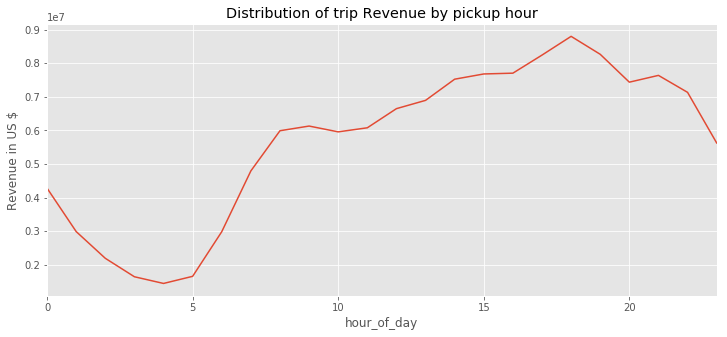

In [14]:
fig,ax = plot.subplots(1,1,figsize=(12,5))
df_kev_hour['total_revenue'].plot(ax=ax)

plot.ylabel('Revenue in US $')
plot.xlabel('hour_of_day')
plot.title('Distribution of trip Revenue by pickup hour')
plot.xlim([0,23])
plot.show()

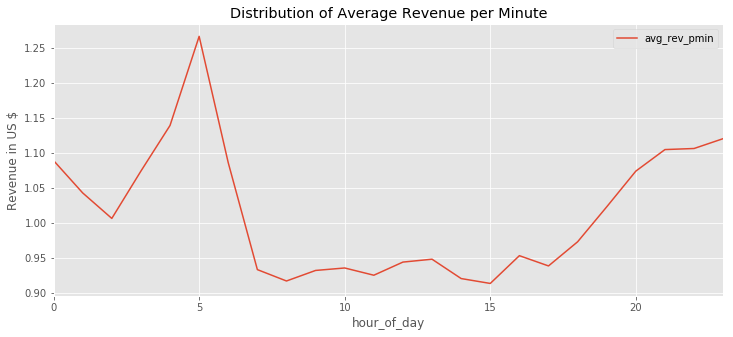

In [15]:
fig,ax = plot.subplots(1,1,figsize=(12,5))
df_kev_hour[['avg_rev_pmin']].plot(ax=ax)

plot.ylabel('Revenue in US $')
plot.xlabel('hour_of_day')
plot.title('Distribution of Average Revenue per Minute')
plot.xlim([0,23])
plot.show()

In [16]:
# Save the figure
fig.savefig("Output_Plots/DistributionoftripRevenuebypickuphour.png")



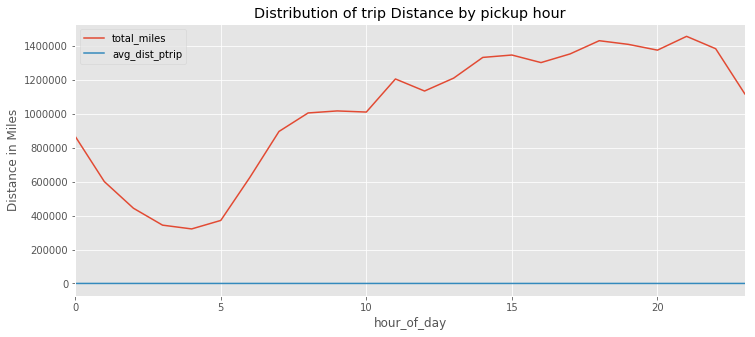

In [17]:
fig,ax = plot.subplots(1,1,figsize=(12,5))
df_kev_hour[['total_miles','avg_dist_ptrip']].plot(ax=ax)

plot.ylabel('Distance in Miles')
plot.xlabel('hour_of_day')
plot.title('Distribution of trip Distance by pickup hour')
plot.xlim([0,23])
plot.show()

In [18]:
# Save the figure
fig.savefig("Output_Plots/Distribution_of_trip_Distance_by_pickup_hour.png")

In [19]:
df_kev_week = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "day_of_week")
df_kev_week

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
day_of_week,,,,,,,,,
Friday,1243810,1.950318e+07,2.051421e+07,3347161.79,16.493044,2.691056,15.680191,0.163163,0.950715
Monday,1272058,2.024929e+07,1.944253e+07,3821349.43,15.284309,3.004069,15.918531,0.196546,1.041495
Saturday,1207628,1.775623e+07,1.888159e+07,3228919.43,15.635271,2.673770,14.703392,0.171009,0.940399
Sunday,1040344,1.581533e+07,1.537222e+07,3076134.19,14.776096,2.956843,15.202018,0.200110,1.028825
Thursday,1089812,1.718430e+07,1.779913e+07,2971200.29,16.332295,2.726342,15.768132,0.166930,0.965457
Tuesday,1408907,2.201610e+07,2.189115e+07,4090159.90,15.537684,2.903073,15.626371,0.186841,1.005708
Wednesday,1496973,2.316918e+07,2.324012e+07,4026709.23,15.524742,2.689901,15.477356,0.173265,0.996948


In [21]:
# Save data frame to CSV
df_kev_week.to_csv('Output_CSV/df_kev_week.csv')

In [22]:
week_end = df_kev_week.drop(['Friday','Monday','Thursday','Tuesday', 'Wednesday'])
week_end

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
day_of_week,,,,,,,,,
Saturday,1207628,1.775623e+07,1.888159e+07,3228919.43,15.635271,2.673770,14.703392,0.171009,0.940399
Sunday,1040344,1.581533e+07,1.537222e+07,3076134.19,14.776096,2.956843,15.202018,0.200110,1.028825


In [23]:
# Save data frame to CSV
week_end.to_csv('Output_CSV/week_end.csv')

In [24]:
working_days = df_kev_week.drop(['Saturday','Sunday'])
working_days

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
day_of_week,,,,,,,,,
Friday,1243810,1.950318e+07,2.051421e+07,3347161.79,16.493044,2.691056,15.680191,0.163163,0.950715
Monday,1272058,2.024929e+07,1.944253e+07,3821349.43,15.284309,3.004069,15.918531,0.196546,1.041495
Thursday,1089812,1.718430e+07,1.779913e+07,2971200.29,16.332295,2.726342,15.768132,0.166930,0.965457
Tuesday,1408907,2.201610e+07,2.189115e+07,4090159.90,15.537684,2.903073,15.626371,0.186841,1.005708
Wednesday,1496973,2.316918e+07,2.324012e+07,4026709.23,15.524742,2.689901,15.477356,0.173265,0.996948


In [25]:
# Save data frame to CSV
working_days.to_csv('Output_CSV/working_days.csv')

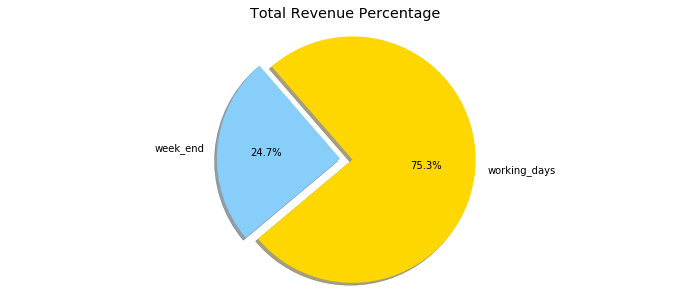

In [26]:
# First let's calculate the total revenue of all 7 Days
total_revenue_all_days = df_kev_hour["total_revenue"].sum()

#Now let's calculate the percentages
total_revenue_working_days = working_days["total_revenue"].sum()
percentage_working_days = ((total_revenue_working_days)/(total_revenue_all_days)*100)

total_revenue_week_end = week_end["total_revenue"].sum()
percentage_week_end = ((total_revenue_week_end)/(total_revenue_all_days)*100)


# Building a Pie Chart
labels=["working_days","week_end"]
sizes = [percentage_working_days,percentage_week_end]
colors=["gold","lightskyblue"]
explode=(0,0.1)
fig,ax = plot.subplots(1,1,figsize=(12,5))
plot.pie(sizes, explode=explode, labels=labels, colors=colors,autopct="%1.1f%%",shadow=True,startangle=220)
plot.axis("equal")
plot.title("Total Revenue Percentage")
plot.show()


In [27]:
# Save the figure
fig.savefig("Output_Plots/Total Revenue Percentage.png")

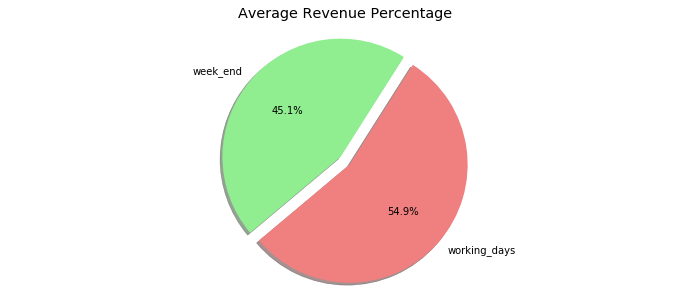

In [28]:
# First let's calculate the total revenue of all 7 Days
average_revenue_all_days = df_kev_hour["total_revenue"].mean()

#Now let's calculate the percentages
average_revenue_working_days = working_days["total_revenue"].mean()
percentage_working_days = ((average_revenue_working_days)/(average_revenue_all_days)*100)

average_revenue_week_end = week_end["total_revenue"].mean()
percentage_week_end = ((average_revenue_week_end)/(average_revenue_all_days)*100)


# Building a Pie Chart
labels=["working_days","week_end"]
sizes = [percentage_working_days,percentage_week_end]
colors=["lightcoral","lightgreen"]
explode=(0,0.1)
fig,ax = plot.subplots(1,1,figsize=(12,5))
plot.pie(sizes, explode=explode, labels=labels, colors=colors,autopct="%1.1f%%",shadow=True,startangle=220)
plot.axis("equal")
plot.title("Average Revenue Percentage")
plot.show()

In [29]:
# Save the figure
fig.savefig("Output_Plots/Average Revenue Percentage.png")

In [30]:
df2_high_volume= df.loc[df['trip_count'] > 100000, :]


df2_high_volume.sort_values(by=['avg_rev_pmin'],ascending= False)

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin
PU_zone_name,,,,,,,,,
JFK Airport,203377,1.152931e+07,8.610943e+06,3220795.69,42.339806,15.836578,56.689338,0.374035,1.338914
LaGuardia Airport,233164,9.821090e+06,7.667790e+06,2279603.83,32.885824,9.776826,42.120953,0.297296,1.280824
NV,155087,2.532395e+06,2.184499e+06,391350.40,14.085636,2.523425,16.328864,0.179149,1.159256
Yorkville East,109302,1.398951e+06,1.371767e+06,237985.19,12.550248,2.177318,12.798954,0.173488,1.019817
Yorkville West,170002,2.074284e+06,2.066557e+06,345998.12,12.156077,2.035259,12.201525,0.167427,1.003739
Lenox Hill West,212473,2.485560e+06,2.504615e+06,394577.14,11.787922,1.857070,11.698237,0.157540,0.992392
Upper West Side North,176926,2.202865e+06,2.232201e+06,362129.27,12.616578,2.046784,12.450769,0.162230,0.986858
Sutton Place/Turtle Bay North,168079,2.112460e+06,2.144819e+06,344077.50,12.760779,2.047118,12.568257,0.160423,0.984913
TriBeCa/Civic Center,146239,2.259184e+06,2.326466e+06,414534.86,15.908657,2.834640,15.448575,0.178182,0.971080


In [73]:
# Save data frame to CSV
df2_high_volume.to_csv('Output_CSV/df2_high_volume.csv')